In [1]:
# Mass estimate of Kepler-10c using RadVel package (https://github.com/California-Planet-Search/radvel.git)

%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots

matplotlib.rcParams['font.size'] = 14

In accordance with NEP 32, the function fv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function ipmt was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function irr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
In accordance with NEP 32, the function nper was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financia

In [2]:
# Loading data for Kepler 10-c from Weiss et.al 2016
data = np.genfromtxt('apj522668t1_ascii.txt', delimiter = '\t', dtype = 'str', skip_header=6, skip_footer = 1) 

Unfortunately, Weiss reported her radial velocity uncertainty with jitter added in. It is certainly possible to obtain the intrinsic RV uncertainty by subtracting the reported telescope-specific jitter value (table 3 in Weiss 2016) in quadrature from the reported total error using the following equation (Equation 1 in Weiss 2016):

$$
\mathcal{L}=\prod_{i} \frac{1}{\sqrt{2 \pi\left(\sigma_{i}^{2}+\sigma_{j}^{2}\right)}} \exp \left[-\frac{\left(\mathrm{RV}_{i}-\mathrm{RV}_{mod, i}\right)^{2}}{2\left(\sigma_{i}^{2}+\sigma_{j}^{2}\right)}\right]
$$

While it likely won't effect our results to use this method, it is best practice to download and read in the fits files from HIRES and HARPS-N instead.

In [3]:
t = data[:,0]
t = np.array([float(i) for i in t])
t 

array([ 173.900499,  174.877797,  175.773348,  176.862854,  177.923401,
        178.922398,  179.972876,  180.896063,  181.969271,  182.847887,
        183.760854,  183.945387,  184.877994,  206.889914,  208.885123,
        208.890922,  211.830107,  269.71177 ,  269.720925,  269.733899,
        270.715114,  270.733655,  272.756489,  273.714025,  273.720425,
        273.727555,  412.04715 ,  413.004124,  414.004814,  415.111272,
        417.998478,  418.121283,  419.027179,  420.062974,  421.006521,
        421.969467,  443.050045,  444.031958,  444.964655,  444.977237,
        445.068315,  450.972744,  451.987745,  473.81361 ,  476.86488 ,
        479.902118,  503.897962,  505.056086,  507.012774,  511.985723,
        512.805268,  514.80255 , 1172.682384, 1172.704768, 1187.57572 ,
       1187.596901, 1203.106739, 1203.661644, 1203.689793, 1215.691945,
       1215.713149, 1216.704755, 1216.719003, 1225.568254, 1225.589446,
       1226.447899, 1226.664948, 1227.422428, 1227.441641, 1228.

In [4]:
rv = data[:,1]
rv = np.array([float(i) for i in rv])
rv

array([  5.21,   0.37,   3.31,   1.1 ,  -6.28,   5.96,   0.9 ,   2.56,
        -9.41,  -8.01,  -1.3 ,  -3.17,  -1.17,   0.64,  -8.82,  -6.76,
        10.61,  -0.59,  -0.77,   5.59,  -0.47,  -6.97,   3.48,   1.35,
         4.13,  -0.49,  -3.91,  -2.11,  -9.03,  -0.13,   2.79,  -2.3 ,
        -0.98,   2.83,   2.53,   1.75,  -1.13,  -1.08,  -3.66,  -8.96,
        -3.82,  -0.41,  -0.93,   3.54,  -1.89,  -0.74,   2.84,  -4.34,
        -1.3 ,  -4.08,  -4.57,  -4.5 ,  -2.7 ,  -3.04,  -1.67,   4.37,
        -5.79,  -0.55,  -4.47,  -3.45,  -7.55,   2.06,  -2.56,  -7.06,
        -8.06,  -2.83,  -0.54, -13.21,   0.41,   2.16,  -2.77,  -1.7 ,
         7.45,  10.45,   3.48,  -0.48,   1.01,   0.59,   2.11,  -5.91,
         4.45,  -1.01,  -3.28,  -4.78,  -5.06,  -8.23,  -6.97,  -9.35,
         1.87,   3.11,   3.74,  -4.07,  -4.84,   0.67,   4.18,   3.13,
        -5.11,   5.83,   3.53,   4.21,   5.13,   2.94,  -0.84, -16.52,
         3.71,   1.78,  -1.19,   0.  ,   4.16,  -8.77,  -0.79,   0.46,
      

In [5]:
rv_error = data[:,2]
rv_error = np.array([float(i) for i in rv_error])
rv_error

array([ 4.18,  3.94,  3.95,  3.96,  3.97,  3.96,  4.  ,  3.94,  3.96,
        3.97,  3.92,  3.99,  3.93,  4.04,  4.28,  5.28,  4.38,  4.22,
        4.08,  4.04,  3.99,  3.98,  4.03,  3.97,  5.03,  4.  ,  3.94,
        3.94,  3.95,  4.12,  3.96,  3.93,  4.06,  3.95,  3.93,  3.97,
        3.9 ,  3.93,  4.34,  3.93,  4.  ,  3.92,  3.95,  3.97,  3.88,
        3.98,  3.89,  4.06,  3.92,  3.86,  3.86,  3.93,  3.05,  3.11,
        3.32,  3.18,  3.9 ,  3.45,  3.32,  3.04,  3.22,  4.47,  4.77,
        3.76,  3.31,  2.94,  4.53,  9.66,  2.91,  2.95,  2.94,  3.14,
        3.22,  3.06,  3.05,  3.33,  2.84,  3.36,  2.98,  4.83,  2.97,
        4.25,  3.98,  3.42,  3.65,  3.33,  3.28,  3.47,  3.27,  3.27,
        3.45,  3.36,  3.48,  3.91,  2.84,  2.97,  3.09,  3.03,  2.91,
        3.02,  2.84,  2.97,  2.81,  9.34,  2.98,  2.86,  2.98,  3.23,
        3.08,  2.93,  2.98,  3.32,  3.25,  3.18,  3.06,  2.94,  2.94,
        2.88,  3.  ,  2.86,  2.84,  3.41,  3.09, 11.61,  5.82,  7.95,
        3.27,  3.19,

In [6]:
inst = data[:,4]
inst = np.array(inst)
inst

array(['HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES', 'HIRES',
       'HIRES', 'HIRES', 'HIRES', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HIRES', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1', 'HARPS-N 1',
       'H

In [7]:
x = radvel.utils.bintels(t,rv,rv_error,inst,binsize = 0.000001) #bins by telescope. can also use list comp. 
hires_t = x[0][:72]
hires_rv = x[1][:72]
hires_rv_error = x[2][:72]
hires_rv_error = np.sqrt(hires_rv_error**2 - 3.62**2) #removing jitter
hires_inst = x[3][:72]


harps_one_t = x[0][72:127]
harps_one_rv = x[1][72:127]
harps_one_rv_error = x[2][72:127]
harps_one_rv_error = np.sqrt(harps_one_rv_error**2 - 2.49**2)
harps_one_inst = x[3][72:127]

harps_two_t = x[0][127:]
harps_two_rv = x[1][127:]
harps_two_rv_error = x[2][127:]
harps_two_rv_error = np.sqrt(harps_two_rv_error**2 - 2.49**2)
harps_two_inst = x[3][127:]

gamma_hires = np.median(x[1][:72]) # median of binned radial velocity data for HIRES observation
gamma_harps_one = np.median(x[1][72:127])
gamma_harps_two = np.median(x[1][127:])


In [8]:
hires = [hires_t,hires_rv,hires_rv_error,hires_inst] #hires data
harps_one = [harps_one_t,harps_one_rv,harps_one_rv_error,harps_one_inst]
harps_two = [harps_two_t,harps_two_rv,harps_two_rv_error,harps_two_inst]

t_new = []
t_new.extend(harps_one_t)
t_new.extend(harps_two_t)
t_new = np.array(t_new)

rv_new = []
rv_new.extend(hires_rv)
rv_new.extend(harps_one_rv)
rv_new.extend(harps_two_rv)
rv_new = np.array(rv_new)

rv_error_new = []
rv_error_new.extend(hires_rv_error)
rv_error_new.extend(harps_one_rv_error)
rv_error_new.extend(harps_two_rv_error)
rv_error_new  = np.array(rv_error_new)

inst_new = []
inst_new.extend(hires_inst)
inst_new.extend(harps_one_inst)
inst_new.extend(harps_two_inst)
inst_new = np.array(inst_new)

hires

[array([ 173.900499,  174.877797,  175.773348,  176.862854,  177.923401,
         178.922398,  179.972876,  180.896063,  181.969271,  182.847887,
         183.760854,  183.945387,  184.877994,  206.889914,  208.885123,
         208.890922,  211.830107,  269.71177 ,  269.720925,  269.733899,
         270.715114,  270.733655,  272.756489,  273.714025,  273.720425,
         273.727555,  412.04715 ,  413.004124,  414.004814,  415.111272,
         417.998478,  418.121283,  419.027179,  420.062974,  421.006521,
         421.969467,  443.050045,  444.031958,  444.964655,  444.977237,
         445.068315,  450.972744,  451.987745,  473.81361 ,  476.86488 ,
         479.902118,  503.897962,  505.056086,  507.012774,  511.985723,
         512.805268,  514.80255 , 1203.106739, 1272.8013  , 1926.898038,
        1942.001946, 1942.954468, 1943.951042, 1962.874534, 1963.860172,
        1964.900473, 1965.945739, 1982.934778, 1983.770615, 1989.012469,
        2006.909888, 2007.77185 , 2008.976767, 2009

In [9]:
hires = [hires_t,hires_rv,hires_rv_error,hires_inst] #hires data
harps_one = [harps_one_t,harps_one_rv,harps_one_rv_error,harps_one_inst]
harps_two = [harps_two_t,harps_two_rv,harps_two_rv_error,harps_two_inst]
starname = 'Kepler 10'
instnames = ['hires', 'harps_one', 'harps_two']
nplanets = 3    # number of planets in the system
planet_letters = {1: 'b', 2: 'c' ,3: 'x'}   # map the numbers in the Parameters keys to planet letters (for plotting and tables)

In [10]:
def initialize_model():
    time_base = 0 #BJD: barycentric julian date: center of mass from solar system (barycentric correction b/c different sides of solar system from earth)
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw logk')
    params['per1'] = radvel.Parameter(value=0.837491331) # period [days]
    params['tc1'] = radvel.Parameter(value=2454964.57475-2454900) # time of transit
    params['secosw1'] = radvel.Parameter(value=0) #sqrt(e)*cos(omega)
    params['sesinw1'] = radvel.Parameter(value=0) #sqrt(e)*sin(omega)
    params['logk1'] = radvel.Parameter(value=0.518514) # log(semi-amplitude)
    params['per2'] = radvel.Parameter(value=45.29431717)
    params['tc2'] = radvel.Parameter(value= 2454971.67748-2454900)
    params['secosw2'] = radvel.Parameter(value=0)
    params['sesinw2'] = radvel.Parameter(value=0)
    params['logk2'] = radvel.Parameter(value=0.149219113)
    params['logk3'] = radvel.Parameter(value=1)
    params['tc3'] = radvel.Parameter(value= 0)
    params['per3'] = radvel.Parameter(value=102)
    params['secosw3'] = radvel.Parameter(value=0)
    params['sesinw3'] = radvel.Parameter(value=0)
    mod = radvel.model.RVModel(params)
    mod.params['dvdt'] = radvel.Parameter(value=0) # short term linear shift for binary system
    mod.params['curv'] = radvel.Parameter(value=0) # long term quadratic shift for binary system
    return mod

# By reparameterizing eccentricity/argument of periastron in this way, we create a circle where the distance from the 
# center of the circle corresponds to the eccentricity (i.e points on the edge correspond to e=1, points in the middle 
# correspond to e=0). This helps mitigate against an artificial build up of eccentricities near zero (it would otherwise be 
# difficult to tell if e=0 build up is due to a boundary condition at e=0 or not).

# Exploring semi-amplitude in log-space -> explore lower values more often 

# Transit time selection is a bit more nuanced than it initially appears. If data for transit time occurs well-
# before or well-after rv data then we have to worry about aliasing (see stale ephemerides). 
# Not a problem for Kepler-10 data


In [11]:
def initialize_likelihood(t,rv,rv_error,suffix):
    like = radvel.likelihood.RVLikelihood(
        mod, t, rv, rv_error, suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES likelihood
like_hires = initialize_likelihood(hires_t,hires_rv,hires_rv_error,'_hires')
like_hires.params['gamma_hires'] = radvel.Parameter(gamma_hires)
like_hires.params['jit_hires'] = radvel.Parameter(value=3.62)

# Build up HARPS-1 likelihood
like_harps_one = initialize_likelihood(harps_one_t,harps_one_rv,harps_one_rv_error,'_harps_one')
like_harps_one.params['gamma_harps_one'] = radvel.Parameter(gamma_harps_one)
like_harps_one.params['jit_harps_one'] = radvel.Parameter(value=2.49)

# Build up HARPS-2 likelihood
like_harps_two = initialize_likelihood(harps_two_t,harps_two_rv,harps_two_rv_error,'_harps_two')
like_harps_two.params['gamma_harps_two'] = radvel.Parameter(gamma_harps_two)
like_harps_two.params['jit_harps_two'] = radvel.Parameter(value=2.49)

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood([like_hires,like_harps_one,like_harps_two])
like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False
like.params['secosw2'].vary = False
like.params['sesinw2'].vary = False
like.params['secosw3'].vary = False
like.params['sesinw3'].vary = False
like.params['per1'].vary = True
like.params['per2'].vary = True
like.params['per3'].vary = True
like.params['tc1'].vary = True
like.params['tc2'].vary = True
like.params['tc3'].vary = True
like.params['dvdt'].vary= False
like.params['curv'].vary= False
print(like)


parameter                     value      vary
per1                       0.837491       True
tc1                         64.5748       True
secosw1                           0      False
sesinw1                           0      False
logk1                      0.518514       True
per2                        45.2943       True
tc2                         71.6775       True
secosw2                           0      False
sesinw2                           0      False
logk2                      0.149219       True
per3                            102       True
tc3                               0       True
secosw3                           0      False
sesinw3                           0      False
logk3                             1       True
dvdt                              0      False
curv                              0      False
gamma_hires                  -0.375       True
jit_hires                      3.62       True
gamma_harps_one               -0.55       True
jit_harps_one 

In [12]:
import copy

# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
# Uniform priors for everything but period/transit time

# Period and Transit time from transit modelling in Morton et al. 2016. While, Gajdoš et al. 2019 provided slightly
# better constraints for period/transit time, period/transit time are very well constrained across all papers,
# so we place an outsized importance on the estimate of planet radius which will be used to calculate planet density. 
# An estimate for planet radius was not reported in Gajdoš 2019. 

post.priors += [radvel.prior.EccentricityPrior(nplanets)] # Keeps eccentricity < 1
post.priors += [radvel.prior.HardBounds( 'logk3', -1, 4)]
post.priors += [radvel.prior.HardBounds( 'logk2', -1, 4)]
post.priors += [radvel.prior.HardBounds( 'logk1', -1, 4)]
post.priors += [radvel.prior.Gaussian('per2',45.29431717, 0.00005283)]
post.priors += [radvel.prior.Gaussian('tc2',2454971.67748-2454900,0.00089)]
post.priors += [radvel.prior.Gaussian('per1',0.837491331,0.000000272)]
post.priors += [radvel.prior.Gaussian('tc1',2454964.57475-2454900,0.000261)]
post.priors += [radvel.prior.HardBounds('per3', 50, 200)]
post.priors += [radvel.prior.HardBounds('tc3',-100,100)]
post.priors += [radvel.prior.HardBounds( 'gamma_hires', gamma_hires - 3*np.std(x[1][:72]), gamma_hires + 3*np.std(x[1][:72]))]
post.priors += [radvel.prior.HardBounds( 'gamma_harps_one', gamma_harps_one - 3*np.std(x[1][72:127]),gamma_harps_one+ 3*np.std(x[1][72:127]))]
post.priors += [radvel.prior.HardBounds( 'gamma_harps_two', gamma_harps_two - 3*np.std(x[1][127:]),gamma_harps_two + 3*np.std(x[1][127:]))]
post.priors += [radvel.prior.HardBounds( 'jit_hires', 0, 10)] 
post.priors += [radvel.prior.HardBounds( 'jit_harps_one', 0, 10)] 
post.priors += [radvel.prior.HardBounds( 'jit_harps_two', 0, 10)] 


print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -603.572526
Final loglikelihood = -598.990252
parameter                     value      vary
per1                       0.837491       True
tc1                         64.5748       True
secosw1                           0      False
sesinw1                           0      False
logk1                      0.518514       True
per2                        45.2943       True
tc2                         71.6775       True
secosw2                           0      False
sesinw2                           0      False
logk2                      0.149219       True
per3                            102       True
tc3                               0       True
secosw3                           0      False
sesinw3                           0      False
logk3                             1       True
dvdt                              0      False
curv                              0      False
gamma_hires                  -0.375       True
jit_hires                      3.62   

In [13]:
df = radvel.mcmc(post,nwalkers=45,nrun=15000, savename='rawchains.h5', minTz=False)
# G-R: Gelman Rubin Metric: how much variation within a given chain versus how much variation between all of the chains
# < 1.01


270000/5400000 (5.0%) steps complete; Running 1027.72 steps/s; Mean acceptance rate = 35.5%; Min Auto Factor =  28; Max Auto Relative-Change =   inf; Min Tz = 315.2; Max G-R = 1.103
Discarding burn-in now that the chains are marginally well-mixed

738000/5400000 (13.7%) steps complete; Running 1201.07 steps/s; Mean acceptance rate = 34.5%; Min Auto Factor =  55; Max Auto Relative-Change = 0.028; Min Tz = 4015.5; Max G-R = 1.0077
Chains are well-mixed after 738000 steps! MCMC completed in 10.2 minutes




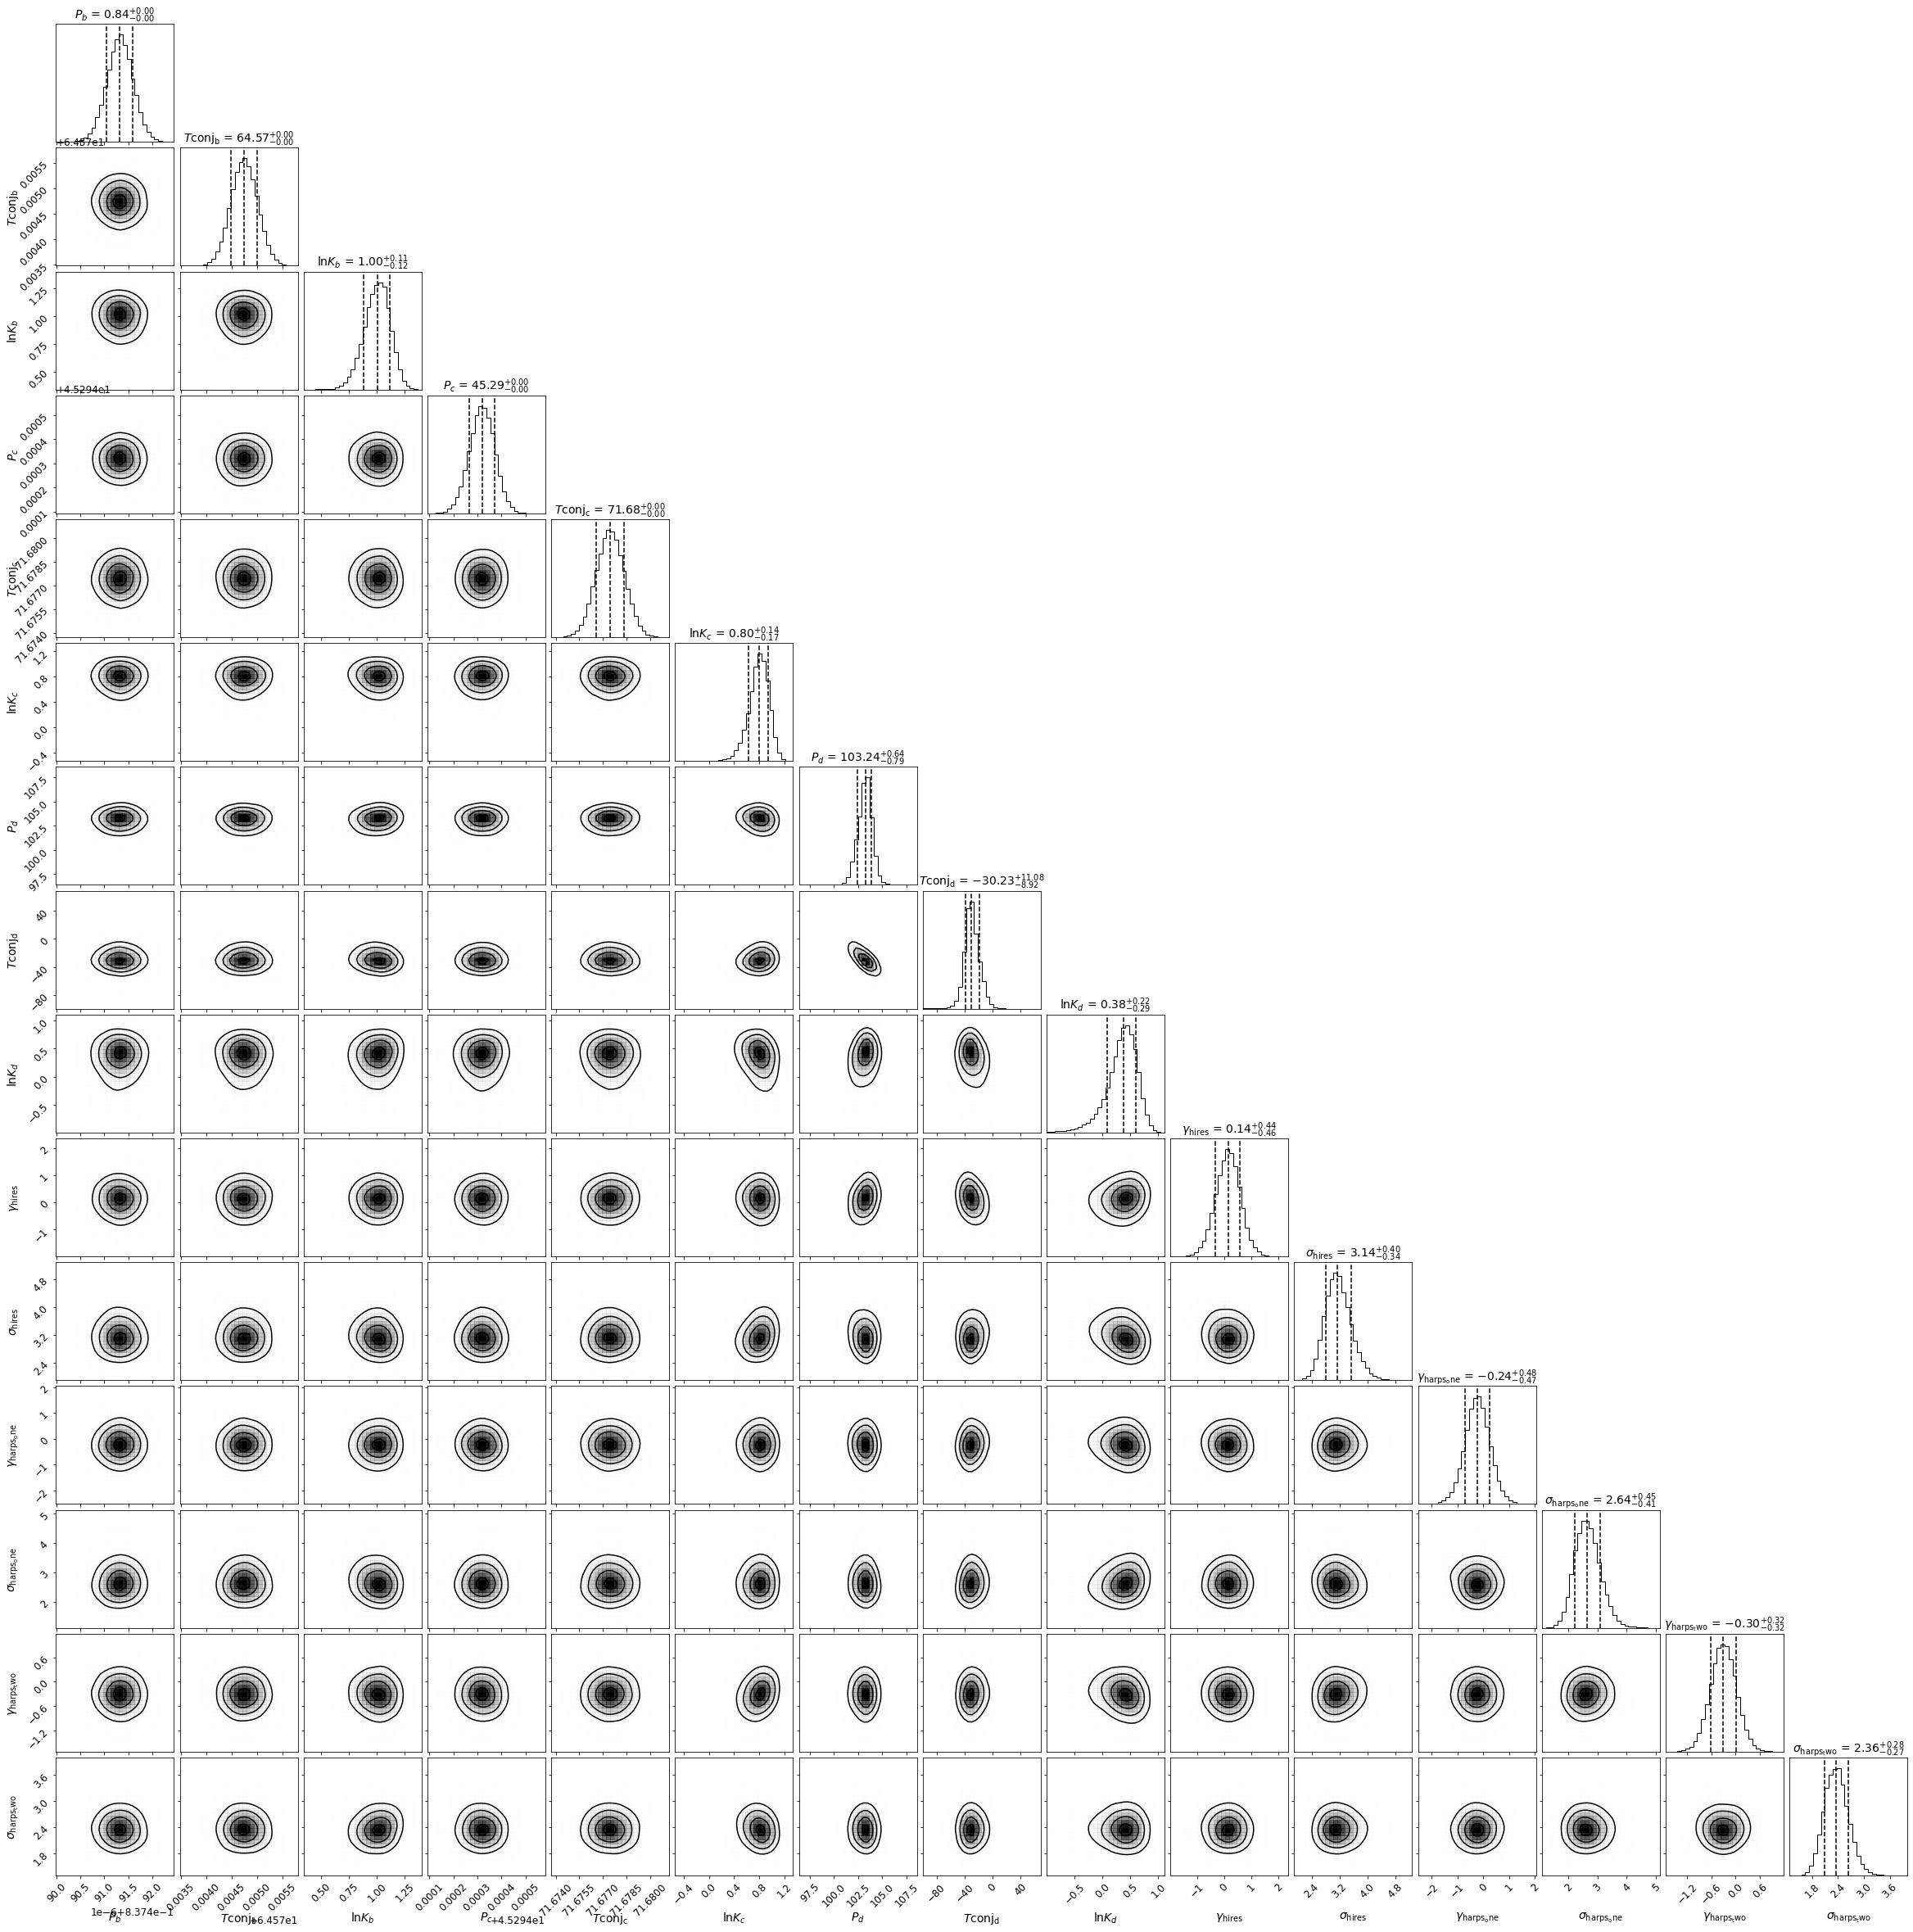

In [14]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

In [15]:
# Ec = df.sesinw2**2 + df.secosw2**2
# import matplotlib.pyplot as plt
# plt.hist(np.log10(Eb),bins=400); plt.show()

In [16]:
# sum(Ec < 0.0000001)/len(Ec)

(<Figure size 540x1018.29 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc4c693f130>])

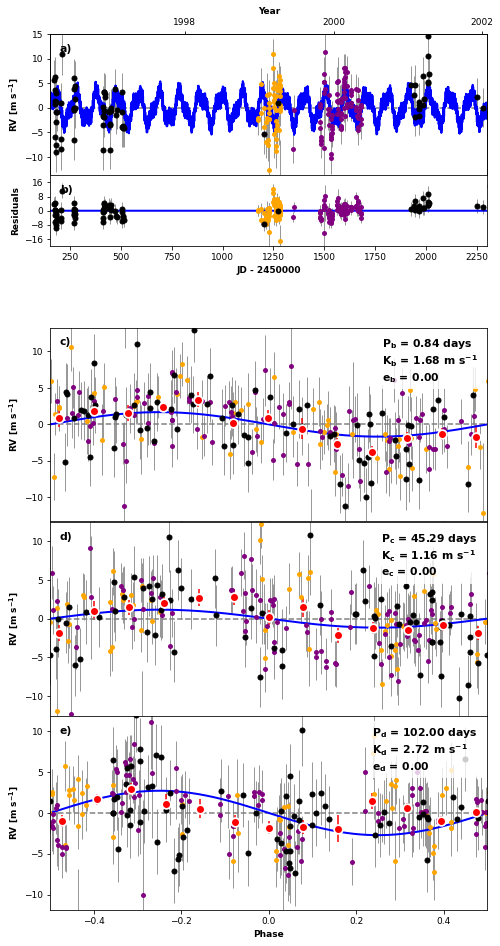

In [17]:
RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
RVPlot.plot_multipanel()

In [26]:
df

,per1,tc1,logk1,per2,tc2,logk2,per3,tc3,logk3,gamma_hires,jit_hires,gamma_harps_one,jit_harps_one,gamma_harps_two,jit_harps_two,lnprobability
0,0.837491,64.574480,1.156214,45.294248,71.679371,0.920030,102.150578,-17.711579,-0.035578,-0.270244,3.253137,0.001636,2.708044,-0.453201,2.532687,-574.783929
1,0.837491,64.574480,1.156214,45.294248,71.679371,0.920030,102.150578,-17.711579,-0.035578,-0.270244,3.253137,0.001636,2.708044,-0.453201,2.532687,-574.783929
2,0.837491,64.574480,1.156214,45.294248,71.679371,0.920030,102.150578,-17.711579,-0.035578,-0.270244,3.253137,0.001636,2.708044,-0.453201,2.532687,-574.783929
3,0.837492,64.574496,1.188199,45.294242,71.679540,0.917682,102.128420,-17.178455,-0.047304,-0.212169,3.163783,-0.017655,2.795722,-0.459470,2.533847,-576.086853
4,0.837492,64.574496,1.188199,45.294242,71.679540,0.917682,102.128420,-17.178455,-0.047304,-0.212169,3.163783,-0.017655,2.795722,-0.459470,2.533847,-576.086853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467995,0.837491,64.574713,1.092805,45.294310,71.677307,0.910627,103.187560,-29.560729,-0.229173,-0.013256,3.284648,-0.299334,2.390377,0.111992,2.346231,-570.091859
467996,0.837491,64.574713,1.092805,45.294310,71.677307,0.910627,103.187560,-29.560729,-0.229173,-0.013256,3.284648,-0.299334,2.390377,0.111992,2.346231,-570.091859
467997,0.837491,64.574713,1.092805,45.294310,71.677307,0.910627,103.187560,-29.560729,-0.229173,-0.013256,3.284648,-0.299334,2.390377,0.111992,2.346231,-570.091859
467998,0.837491,64.574713,1.092805,45.294310,71.677307,0.910627,103.187560,-29.560729,-0.229173,-0.013256,3.284648,-0.299334,2.390377,0.111992,2.346231,-570.091859


In [19]:
k_c = np.array(df.logk2)
k_c = np.power(np.e,k_c)
per_c = np.array(df.per2)
# ecc_c = np.array(df.secosw2)**2 + np.array(df.sesinw2)**2
# ecc_b = np.array(df.secosw1)**2 + np.array(df.sesinw1)**2
# ecc_d = np.array(df.secosw3)**2 + np.array(df.secosw3)**2
stellar_mass_median = 0.92
stellar_mass_unc = 0.018
stellar_mass = np.random.randn(len(k_c))*stellar_mass_unc + stellar_mass_median

In [23]:
mass = radvel.utils.Msini(k_c, per_c, stellar_mass, 0, Msini_units='earth')
print('Mass estimate of Kepler-10c:' , np.median(mass))
lo, med, hi = np.percentile(mass, [16, 50, 84])
uerr, lerr = hi - med, med - lo
print('Upper Error:', uerr, ', Lower Error:',lerr)

Mass estimate of Kepler-10c: 11.724875905610617
Upper Error: 1.7996552332120892 , Lower Error: 1.8013394107203826


In [24]:
k_b = np.array(df.logk1)
k_b = np.power(np.e,k_b)
per_b = np.array(df.per1)
mass_b = radvel.utils.Msini(k_b, per_b, stellar_mass, 0, Msini_units='earth')
print('Mass estimate of Kepler-10b:' , np.median(mass_b))
lo_b, med_b, hi_b = np.percentile(mass_b, [16, 50, 84])
uerr_b, lerr_b = hi_b - med_b, med_b - lo_b
print('Upper Error:', uerr_b, ', Lower Error:',lerr_b)

Mass estimate of Kepler-10b: 3.802093999100171
Upper Error: 0.43467487219316103 , Lower Error: 0.43903960041493884


In [ ]:
# Next step: implement GP on top of existing code to improve fitting. 